In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# replicate figure 7 from carlsten 

setup: calculate the proportion of transaction fees earned by an adversary playing the pure selfish strategy given block times modelled as an exponential distribution.

In [264]:
state = [0,0] # (attacker, honest)
alpha = 0.3

honestBlcs = 0
attackBlcs = 0

for _ in tqdm(range(int(1e5))):
    attBlock  = np.random.binomial(1, alpha)

    if state == [0,0]:
        if attBlock:
            state = [1,0]
        else:
            honestBlcs += 1
        continue
    
    if state == [1,0]:
        if attBlock:
            state = [2,0]
        else:
            nextAttBlock  = np.random.binomial(1, alpha)
            if nextAttBlock:
                attackBlcs += 2
            else:
                honestBlcs += 2
            state = [0,0]
        continue
        
    if attBlock:
        state[0] += 1
    else:
        state[1] += 1
    
    diff = state[0] - state[1]
    if diff == 1:
        attackBlcs += state[0]
        state = [0,0]

totalBlcs = honestBlcs + attackBlcs
(honestBlcs/totalBlcs, attackBlcs/totalBlcs), honestBlcs, totalBlcs

100%|██████████| 100000/100000 [00:00<00:00, 258374.64it/s]


((0.7287714014834644, 0.27122859851653564), 65338, 89655)

In [273]:
def simNoGamma(alpha, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    for _ in range(n):
        attBlock  = np.random.binomial(1, alpha)

        if state == [0,0]:
            if attBlock:
                state = [1,0]
            else:
                honestBlcs += 1
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
            else:
                nextAttBlock  = np.random.binomial(1, alpha)
                if nextAttBlock:
                    attackBlcs += 2
                else:
                    honestBlcs += 2
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            state = [0,0]

    totalBlcs = honestBlcs + attackBlcs
    return attackBlcs/totalBlcs

In [19]:
def EyalSirer(a, g):
    num = a * ((1-a)**2) * (4*a + g*(1-2*a)) - a**3
    den = 1 - a * (1 + (2-a) * a)
    return num / den

In [20]:
EyalSirer(0.3, 0)

0.27312614259597795

In [265]:
alphas = np.arange(0.01, 0.5, 0.001)
g0s    = [EyalSirer(a, 0) for a in alphas]

In [ ]:
simAlphas = np.arange(0.025, 0.5, 0.025)
simg0s = []
for i, a in tqdm(enumerate(simAlphas)):
    temp = []
    for j in range(10):
        temp.append(simNoGamma(a))
    simg0s.append(np.mean(temp))

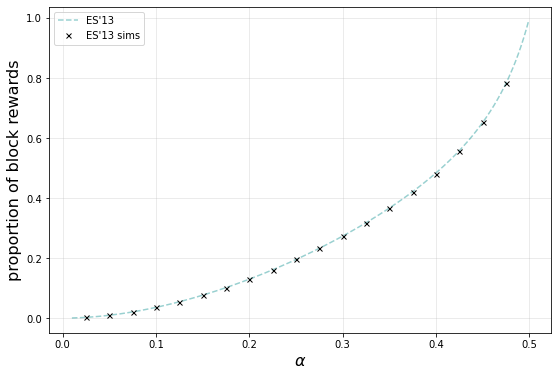

In [301]:
f, ax = plt.subplots(figsize=(9,6))

ax.plot(alphas, g0s, label='ES\'13', linestyle='--', color='darkcyan', alpha=0.4)
ax.plot(simAlphas, simg0s, linestyle='none', color='black', marker='x', fillstyle='none',
        markersize=5, label='ES\'13 sims')

ax.grid(alpha=0.3)
ax.set_xlabel(r'$\alpha$', size=16)
ax.set_ylabel(r'proportion of block rewards', size=16)
# ax.set_xlim(0.25, 0.4)
# ax.set_ylim(0.2,0.45)
ax.legend()
plt.show()

# adding txn fees

In [5]:
def Carlsten2(alpha, beta, gamma=0):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

In [3]:
def Carlsten(a, g):
    num = 5*(a**2) - 12*(a**3) + 9*(a**4) - 2*(a**5) + g * (a - 4*(a**2) + 6*(a**3) - 5*(a**4) + 2*(a**5))
    den = 2*(a**3) - 4*(a**2) + 1
    return num / den

In [8]:
Carlsten(0.3, 0), Carlsten2(0.3, 100)

(0.27959654178674354, 0.290958904109589)

In [684]:
Carlsten(0.3, 1), Carlsten2(0.3, 100, gamma=1), selfishCNum(0.3, 1)

(0.37521613832853024, 0.37150684931506844, 0.37150684931506844)

In [691]:
simCKWN(alpha=0.3, gamma=0.5)

0.3671966104056911

In [712]:
## SYMBOLIC INTERLUDE
a, b, g = sp.symbols('alpha beta gamma')

num1 = 1 + b * (1-a)**2 * (1-g)
den1 = sp.exp(b) - 1

expr1 = num1 / den1
expr2 = 5*a + (1-a)**2 * g + 2*a**2/(1-2*a) - 2*a**2
expr3 = expr1 + expr2

num2 = a * (1-2*a) * (1-sp.exp(-b))
den2 = 1 - 2 * sp.exp(-b) * a - 3 * (1-sp.exp(-b)) * a**2
expr4 = num2 / den2

full = expr3 * expr4
full

alpha*(1 - 2*alpha)*(1 - exp(-beta))*(-2*alpha**2 + 2*alpha**2/(1 - 2*alpha) + 5*alpha + gamma*(1 - alpha)**2 + (beta*(1 - alpha)**2*(1 - gamma) + 1)/(exp(beta) - 1))/(-alpha**2*(3 - 3*exp(-beta)) - 2*alpha*exp(-beta) + 1)

In [716]:
full.evalf(subs={a:0.3, b:3, g:1}), Carlsten2(alpha=0.3, beta=3, gamma=1)

(0.369511185225308, 0.3695111852253081)

In [518]:
selfishC = sp.limit(full, b, sp.oo)
selfishC

(2*alpha**4*gamma - 4*alpha**4 - 5*alpha**3*gamma + 10*alpha**3 + 4*alpha**2*gamma - 5*alpha**2 - alpha*gamma)/(3*alpha**2 - 1)

In [526]:
selfishCNum = sp.lambdify((a, g), selfishC)
selfishCNum(0.3, 0)

0.290958904109589

In [527]:
alphas  = np.arange(0.01, 0.5, 0.001)
g0sC    = [Carlsten(a, 0) for a in alphas]
g0sC2   = [selfishCNum(a, 0) for a in alphas]

In [459]:
state = [0,0] # (attacker, honest)
alpha = 0.3

honestBlcs = 0
attackBlcs = 0
honestRews = 0
attackRews = 0
curTime    = 0
lastState0 = 0
lastAttBlc = 0

for _ in tqdm(range(int(1e5))):
    attBlock = np.random.binomial(1, alpha)
    execRews = np.random.exponential(100)
    curTime += execRews

    if state == [0,0]:
        if attBlock:
            state = [1,0]
            lastAttBlc = curTime
        else:
            honestBlcs += 1
            honestRews += execRews
            lastState0  = curTime
        continue
    
    if state == [1,0]:
        if attBlock:
            state = [2,0]
            lastAttBlc = curTime
        else:
            nextAttBlock  = np.random.binomial(1, alpha)
            nextExecRews  = np.random.exponential()
            curTime      += nextExecRews
            if nextAttBlock:
                attackBlcs += 2
                attackRews += (curTime - lastState0)
                lastState0  = curTime
            else:
                honestBlcs += 2
                honestRews += (curTime - lastState0)
                lastState0  = curTime
            state = [0,0]
        continue
        
    if attBlock:
        state[0] += 1
        lastAttBlc = curTime
    else:
        state[1] += 1
    
    diff = state[0] - state[1]
    if diff == 1:
        attackBlcs += state[0]
        attackRews += (lastAttBlc - lastState0)
        
        # 0'' state
        remRews = (curTime - lastAttBlc)
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential(100)
        if attBlock:
            attackRews += (remRews + execRews)
        else:
            honestRews += (remRews + execRews)
        
        lastState0  = curTime
        lastAttBlc  = curTime
        state = [0,0]

totalRews = honestRews + attackRews
totakBlcs = honestBlcs + attackBlcs
(honestRews/totalRews, attackRews/totalRews), (honestBlcs/totakBlcs, attackBlcs/totakBlcs)

100%|██████████| 100000/100000 [00:00<00:00, 134653.83it/s]


((0.7172528553880362, 0.2827471446119637),
 (0.7313565538242681, 0.2686434461757318))

In [479]:
def simNoGammaC(alpha, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential()
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                state = [1,0]
                lastAttBlc = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                nextAttBlock  = np.random.binomial(1, alpha)
                nextExecRews  = np.random.exponential()
                curTime      += nextExecRews
                if nextAttBlock:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0)
                    lastState0  = curTime
                    lastAttBlc  = curTime
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0)
                    lastState0  = curTime
                    lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackRews += (remRews + execRews)
            else:
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    return attackRews/totalRews

In [480]:
simAlphas = np.arange(0.025, 0.5, 0.025)
simg0sC = []
for i, a in tqdm(enumerate(simAlphas)):
    temp = []
    for j in range(10):
        temp.append(simNoGammaC(a))
    simg0sC.append(np.mean(temp))

19it [02:06,  6.93s/it]

KeyboardInterrupt: 

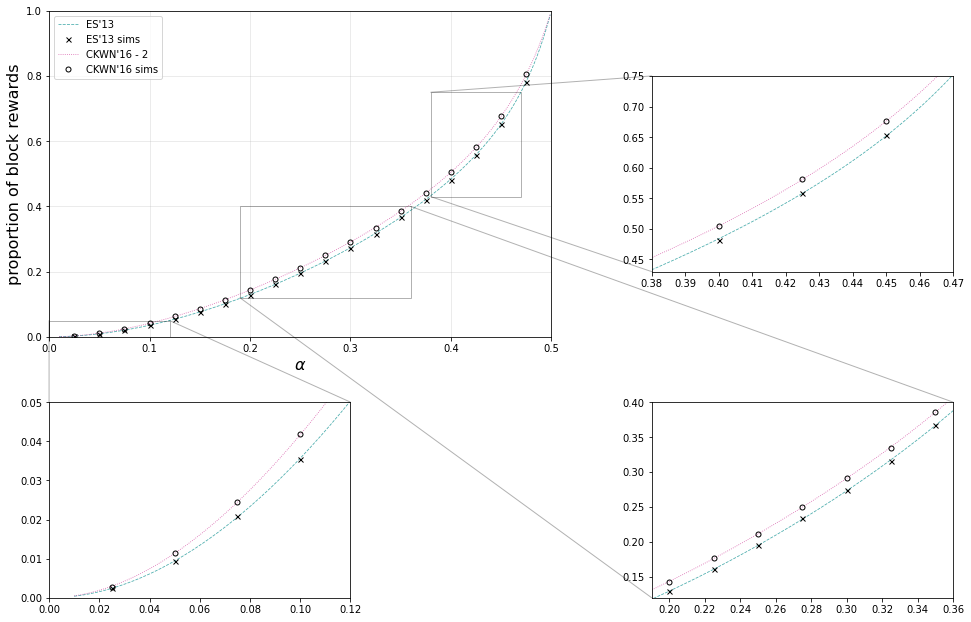

In [531]:
f, ax = plt.subplots(figsize=(9,6))

axins0 = ax.inset_axes([0., -0.8, 0.6, 0.6], xlim=(0., 0.12), ylim=(0., .05))
axins1 = ax.inset_axes([1.2, 0.2, 0.6, 0.6], xlim=(0.38, 0.47), ylim=(0.43, 0.75))
axins2 = ax.inset_axes([1.2, -0.8, 0.6, 0.6], xlim=(0.19, 0.36), ylim=(0.12, 0.4))
ax.indicate_inset_zoom(axins0, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins1, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins2, edgecolor="black", label=None, alpha=0.3)

for a in [ax, axins0, axins1, axins2]:
    a.plot(alphas, g0s, label='ES\'13', linestyle='--', color='darkcyan', alpha=0.7, linewidth=0.8)
    a.plot(simAlphas, simg0s, linestyle='none', color='black', marker='x', fillstyle='none',
            markersize=5, label='ES\'13 sims')

#     a.plot(alphas, g0sC, label='CKWN\'16', linestyle='--', color='mediumvioletred', alpha=0.7, linewidth=0.8)
    a.plot(alphas, g0sC2, label='CKWN\'16 - 2', linestyle='dotted', color='mediumvioletred', alpha=0.7, linewidth=0.8)
    a.plot(simAlphas, simg0sC, linestyle='none', color='black', marker='o', fillstyle='none',
            markersize=5, label='CKWN\'16 sims')

ax.grid(alpha=0.3)
ax.set_xlabel(r'$\alpha$', size=16)
ax.set_ylabel(r'proportion of block rewards', size=16)
ax.set_xlim(0., 0.5)
ax.set_ylim(0.,1)
ax.legend()
plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')

plt.show()

# more gammas

In [566]:
alphas     = np.arange(0.01, 0.5, 0.001)
gammas     = [0, 0.5, 1]

ES_theo    = []
CKWN2_theo = []
for g in gammas:
    ES_theo.append([EyalSirer(a, g) for a in alphas])
    CKWN2_theo.append([selfishCNum(a, g) for a in alphas])
ES_theo    = np.array(ES_theo)
CKWN2_theo = np.array(CKWN2_theo)
ES_theo.shape, CKWN2_theo.shape

((3, 490), (3, 490))

In [565]:
def simES(alpha, gamma, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    for _ in range(n):
        attBlock  = np.random.binomial(1, alpha)

        if state == [0,0]:
            if attBlock:
                state = [1,0]
            else:
                honestBlcs += 1
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
            else:
                sample = np.random.uniform()
                if sample < alpha:
                    attackBlcs += 2
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                else: 
                    honestBlcs += 2
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            state = [0,0]

    totalBlcs = honestBlcs + attackBlcs
    return attackBlcs/totalBlcs

In [597]:
simES(alpha=0.3, gamma=0.5, n=int(1e4))

0.32333666555592583

In [602]:
simAlphas = np.arange(0.025, 0.5, 0.025)
ES_sim = []
for g in gammas:
    temp = []
    for a in simAlphas:
        print('alpha={:0.3f}, gamma={:0.3f}'.format(a,g), end='\r')
        temp2 = []
        for j in range(10):
            temp2.append(simES(a, g, n=int(1e5)))
        temp.append(np.mean(temp2))
    ES_sim.append(temp)
ES_sim = np.array(ES_sim)
ES_sim.shape

(3, 19)

In [692]:
def simCKWN(alpha, gamma, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential()
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                state = [1,0]
                lastAttBlc = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackRews += (remRews + execRews)
            else:
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    return attackRews/totalRews

In [702]:
simCKWN(alpha=0.3, gamma=0.5, n=int(1e4)), simES(alpha=0.3, gamma=0.5, n=int(1e4))

(0.32530817354840674, 0.32473359506449806)

In [703]:
simAlphas = np.arange(0.025, 0.5, 0.025)
CKWN_sim = []
for g in gammas:
    temp = []
    for a in simAlphas:
        print('alpha={:0.3f}, gamma={:0.3f}'.format(a,g), end='\r')
        temp2 = []
        for j in range(10):
            temp2.append(simCKWN(a, g, n=int(1e5)))
        temp.append(np.mean(temp2))
    CKWN_sim.append(temp)
CKWN_sim = np.array(CKWN_sim)
CKWN_sim.shape

(3, 19)

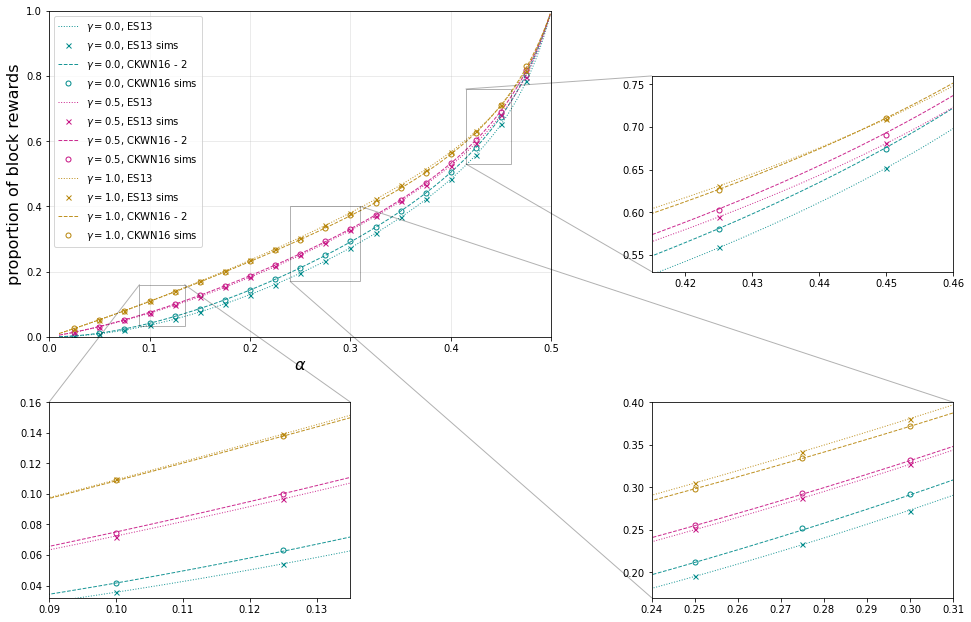

In [705]:
f, ax = plt.subplots(figsize=(9,6))

axins0 = ax.inset_axes([0., -0.8, 0.6, 0.6], xlim=(0.09, 0.135), ylim=(0.032, .16))
axins1 = ax.inset_axes([1.2, -0.8, 0.6, 0.6], xlim=(0.24, 0.31), ylim=(0.17, 0.4))
axins2 = ax.inset_axes([1.2, 0.2, 0.6, 0.6], xlim=(0.415, 0.46), ylim=(0.53, 0.76))
ax.indicate_inset_zoom(axins0, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins1, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins2, edgecolor="black", label=None, alpha=0.3)

colors = ['darkcyan', 'mediumvioletred', 'darkgoldenrod'] 
for a in [ax, axins0, axins1, axins2]:
    for i, g in enumerate(gammas):
        a.plot(alphas, ES_theo[i], label=r'$\gamma=${:0.1f}, ES13'.format(g), 
               linestyle='dotted', color=colors[i], alpha=0.9, linewidth=1)
        a.plot(simAlphas, ES_sim[i], linestyle='none', color=colors[i], marker='x', fillstyle='none',
                markersize=5, label=r'$\gamma=${:0.1f}, ES13 sims'.format(g))

        a.plot(alphas, CKWN2_theo[i], label=r'$\gamma=${:0.1f}, CKWN16 - 2'.format(g),
               linestyle='--', color=colors[i], alpha=0.9, linewidth=1)
        a.plot(simAlphas, CKWN_sim[i], linestyle='none', color=colors[i], marker='o', fillstyle='none',
                markersize=5, label=r'$\gamma=${:0.1f}, CKWN16 sims'.format(g))

ax.grid(alpha=0.3)
ax.set_xlabel(r'$\alpha$', size=16)
ax.set_ylabel(r'proportion of block rewards', size=16)
ax.set_xlim(0., 0.5)
ax.set_ylim(0.,1)
ax.legend()
plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')

plt.show()

# optimal betas

In [718]:
# CKWN optimal betas (exec rewards only)
alphas = np.arange(0.01, 0.5, 0.001)
betas  = np.arange(0.01, 5.01, 0.01)
opt_betas = []
for alpha in tqdm(alphas):
    rews = [Carlsten2(alpha=alpha, beta=b, gamma=0) for b in betas]
    opt_betas.append(betas[np.argmax(rews)])
opt_betas = np.asarray(opt_betas)

100%|██████████| 490/490 [00:06<00:00, 74.75it/s]


In [727]:
CKWN_theo_opt_beta = []
ES_theo            = []
for i in tqdm(range(len(alphas))):
    a, optb = alphas[i], opt_betas[i]
    CKWN_theo_opt_beta.append(Carlsten2(alpha=a, beta=optb, gamma=0))
    ES_theo.append(EyalSirer(a=a, g=0))
CKWN_theo_opt_beta = np.array(CKWN_theo_opt_beta)
ES_theo = np.array(ES_theo)
CKWN_theo_opt_beta.shape, ES_theo.shape

100%|██████████| 490/490 [00:00<00:00, 22962.72it/s]


((490,), (490,))

In [751]:
simAlphas = np.arange(0.025, 0.5, 0.025)
ES_sim = []
for a in simAlphas:
    print('alpha={:0.3f}'.format(a), end='\r')
    temp = []
    for j in range(10):
        temp.append(simES(a, gamma=0, n=int(1e5)))
    ES_sim.append(np.mean(temp))
ES_sim = np.array(ES_sim)
ES_sim.shape

(19,)

In [754]:
def simCKWN_beta(alpha, gamma, beta, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential()
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackRews += (remRews + execRews)
            else:
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    return attackRews/totalRews

In [772]:
alphas[300-10], opt_betas[300-10]

(0.29999999999999977, 0.72)

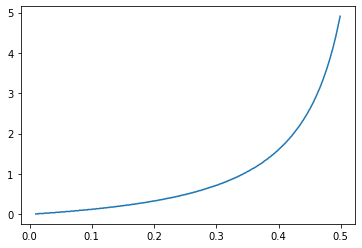

In [756]:
plt.plot(alphas, opt_betas)

In [800]:
Carlsten2(alpha=0.3, gamma=0, beta=opt_betas[300-10]), simCKWN_beta(alpha=0.3, beta=opt_betas[300-10], gamma=0, n=int(1e4))

(0.3302433484455707, 0.3334312101869532)

In [789]:
def findOptBeta(alpha, gamma):
    # CKWN optimal betas (exec rewards only)
    betas  = np.arange(0.01, 5.01, 0.01)
    rews = [Carlsten2(alpha=alpha, beta=b, gamma=gamma) for b in betas]
    return betas[np.argmax(rews)]

In [793]:
findOptBeta(0.3, 0)

0.72

In [803]:
simAlphas = np.arange(0.025, 0.5, 0.025)
CKWN_sim = []
for a in simAlphas:
    optb = findOptBeta(a, 0)
    print('alpha={:0.3f}, optb={:0.3f}'.format(a, optb), end='\r')
    temp = []
    for j in range(10):
        temp.append(simCKWN_beta(alpha=a, gamma=0.0, beta=optb, n=int(1e5)))
    CKWN_sim.append(np.mean(temp))
CKWN_sim = np.array(CKWN_sim)
CKWN_sim.shape

(19,)

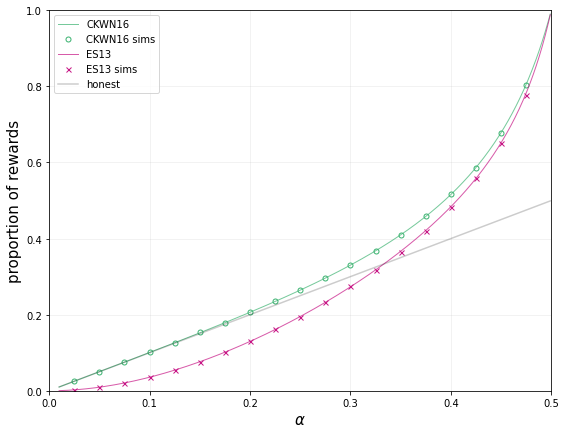

In [808]:
f, ax = plt.subplots(figsize=(9,7))

ax.plot(alphas, CKWN_theo_opt_beta, linewidth=1, color='mediumseagreen', alpha=0.7, label='CKWN16', 
        linestyle='-')
ax.plot(simAlphas, CKWN_sim, color='mediumseagreen', alpha=1, label='CKWN16 sims', marker='o', fillstyle='none',
        linestyle='none', markersize=5)
ax.plot(alphas, ES_theo, linewidth=1, color='mediumvioletred', alpha=0.7, label='ES13',
        linestyle='-')
ax.plot(simAlphas, ES_sim, color='mediumvioletred', alpha=1, label='ES13 sims', marker='x', fillstyle='none',
        linestyle='none', markersize=5)

ax.plot(alphas, alphas, color='k', alpha=0.2, label='honest')

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlim(0., 0.5)
ax.set_ylim(0.,1)

# ax.axvline(0.3)
# ax.axhline(1/3)
plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# add LAMBDA

In [8]:
# adding our rewards
def calcP1(a, b):
    num = a * (2*a-1) * (np.exp(b)-1)
    den = 3 * np.power(a,2) * (np.exp(b)-1) + (2*a) - np.exp(b)
    return num / den

def calcHGamma(a, b, gamma):
    exp1 = (1-a) / (a * (1 - np.exp(-b)))
    exp2 = np.power(1-a, 2) * (2-gamma)
    exp3 = a * (1-a)
    return (exp1 + exp2 + exp3)

def calcAGamma(a, b, gamma):
    exp1 = np.exp(-b) / (a * (1-np.exp(-b)))
    exp2 = 2 - a + ((2-a)/(1-a))
    exp3 = np.power(1-a, 2) * gamma / a
    exp4 = np.power(a,2) / ((1-2*a)*(1-a))
    return a * (exp1 + exp2 + exp3 + exp4)

def calcAOverAHGamma(a, b, gamma):
    return calcAGamma(a,b,gamma) / (calcAGamma(a,b,gamma) + calcHGamma(a,b,gamma))

In [9]:
def calcTotalRewardGamma(a, b, gamma, scale=1):
    return (scale*Carlsten2(alpha=a, beta=b, gamma=gamma) + calcAOverAHGamma(a=a, b=b, gamma=gamma)) / (scale + 1)

In [816]:
# CKWN optimal betas (exec rewards only)
alphas = np.arange(0.01, 0.5, 0.001)
betas  = np.arange(0.01, 5.01, 0.01)
opt_betas_exec = []
for alpha in tqdm(alphas):
    rews = [Carlsten2(alpha=alpha, beta=b, gamma=0) for b in betas]
    opt_betas_exec.append(betas[np.argmax(rews)])
opt_betas_exec = np.asarray(opt_betas_exec)

100%|██████████| 490/490 [00:06<00:00, 74.22it/s]


In [822]:
# our optimal betas (exec & block rewards only)
alphas = np.arange(0.01, 0.5, 0.001)
betas  = np.arange(0.01, 10.01, 0.01)
opt_betas_both = []
for alpha in tqdm(alphas):
    rews = [calcTotalRewardGamma(a=alpha, b=b, gamma=0, scale=1) for b in betas]
    opt_betas_both.append(betas[np.argmax(rews)])
opt_betas_both = np.asarray(opt_betas_exec)

100%|██████████| 490/490 [00:30<00:00, 15.31it/s]

KeyboardInterrupt: 

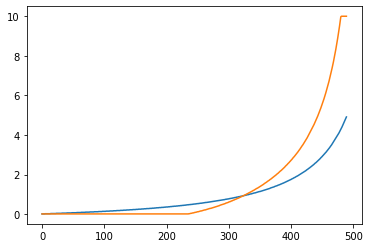

In [823]:
plt.plot(opt_betas_exec)
plt.plot(opt_betas_both)

In [866]:
calcTotalRewardGamma(0.3, 100, 0, scale=1), EyalSirer(0.3,0)

(0.28287224793815646, 0.27312614259597795)

In [2]:
CKWN_theo_opt_beta = []
OURS_theo_opt_beta = []
ES_tho_beta_infty  = []
for i in tqdm(range(len(alphas))):
    a, optb_exec, optb_both = alphas[i], opt_betas_exec[i], opt_betas_both[i]
    CKWN_theo_opt_beta.append(calcTotalRewardGamma(a=a, b=optb_exec, gamma=0, scale=1))
    OURS_theo_opt_beta.append(calcTotalRewardGamma(a=a, b=optb_both, gamma=0, scale=1))
    ES_tho_beta_infty.append(calcTotalRewardGamma(a=a, b=100., gamma=0., scale=1.))
CKWN_theo_opt_beta = np.array(CKWN_theo_opt_beta)
OURS_theo_opt_beta = np.array(OURS_theo_opt_beta)
ES_tho_beta_infty  = np.array(ES_tho_beta_infty)
CKWN_theo_opt_beta.shape, OURS_theo_opt_beta.shape, ES_tho_beta_infty.shape 

NameError: name 'tqdm' is not defined

In [844]:
def simCKWN_beta_lambda(alpha, gamma, beta, scale=1, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential()
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    totalBlcs = honestBlcs + attackBlcs
    return ((scale*(attackRews/totalRews)) + (attackBlcs/totalBlcs)) / (scale+1)

In [845]:
def findOptBetaExec(alpha, gamma):
    # CKWN optimal betas (exec rewards only)
    betas  = np.arange(0.01, 5.01, 0.01)
    rews = [Carlsten2(alpha=alpha, beta=b, gamma=gamma) for b in betas]
    return betas[np.argmax(rews)]

def findOptBetaBoth(alpha, gamma, scale=1):
    # CKWN optimal betas (exec rewards only)
    betas  = np.arange(0.01, 5.01, 0.01)
    rews = [calcTotalRewardGamma(a=alpha, b=b, gamma=gamma, scale=scale) for b in betas]
    return betas[np.argmax(rews)]

In [846]:
findOptBetaExec(0.3, 0), findOptBetaBoth(0.3, 0, scale=1)

(0.72, 0.49)

In [851]:
simAlphas = np.arange(0.025, 0.5, 0.025)
CKWN_sim_lambda = []
for a in simAlphas:
    optb = findOptBetaExec(a, 0)
    print('alpha={:0.3f}, optb={:0.3f}'.format(a, optb), end='\r')
    temp = []
    for j in range(10):
        temp.append(simCKWN_beta_lambda(alpha=a, gamma=0.0, beta=optb, scale=1, n=int(1e5)))
    CKWN_sim_lambda.append(np.mean(temp))
CKWN_sim_lambda = np.array(CKWN_sim_lambda)
CKWN_sim_lambda.shape

(19,)

In [853]:
simAlphas = np.arange(0.025, 0.5, 0.025)
OURS_sim_lambda = []
for a in simAlphas:
    optb = findOptBetaBoth(a, 0)
    print('alpha={:0.3f}, optb={:0.3f}'.format(a, optb), end='\r')
    temp = []
    for j in range(10):
        temp.append(simCKWN_beta_lambda(alpha=a, gamma=0.0, beta=optb, scale=1, n=int(1e5)))
    OURS_sim_lambda.append(np.mean(temp))
OURS_sim_lambda = np.array(OURS_sim_lambda)
OURS_sim_lambda.shape

(19,)

In [875]:
simAlphas = np.arange(0.025, 0.5, 0.025)
ES_sim_lambda = []
for a in simAlphas:
    optb = 100
    print('alpha={:0.3f}'.format(a), end='\r')
    temp = []
    for j in range(10):
        temp.append(simCKWN_beta_lambda(alpha=a, gamma=0.0, beta=optb, scale=1, n=int(1e5)))
    ES_sim_lambda.append(np.mean(temp))
ES_sim_lambda = np.array(ES_sim_lambda)
ES_sim_lambda.shape

(19,)

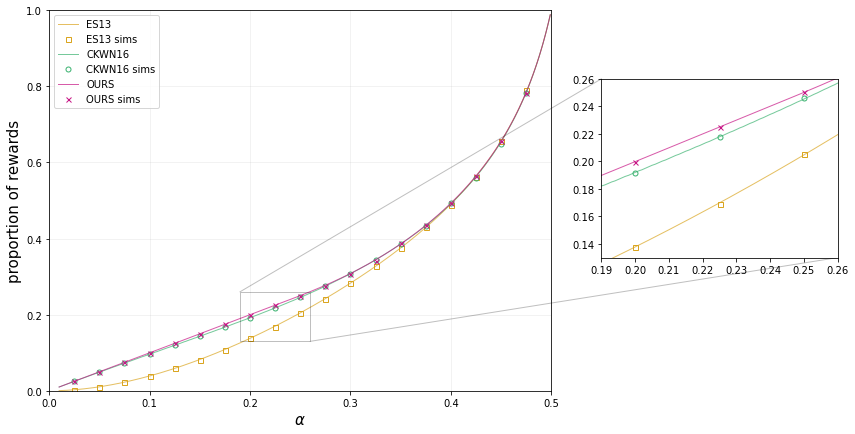

In [880]:
f, ax = plt.subplots(figsize=(9,6))

axins = ax.inset_axes(
    [1.1, 0.35, 0.47, 0.47],
    xlim=(.19, .26), ylim=(.13, .26))

ax.indicate_inset_zoom(axins, edgecolor="black", label=None, alpha=0.25)


for a in [ax, axins]:
    a.plot(alphas, ES_tho_beta_infty, linewidth=1, color='goldenrod', alpha=0.7, label='ES13', 
            linestyle='-')
    a.plot(simAlphas, ES_sim_lambda, color='goldenrod', alpha=1, label='ES13 sims', marker='s', 
           fillstyle='none', linestyle='none', markersize=5)
        
    a.plot(alphas, CKWN_theo_opt_beta, linewidth=1, color='mediumseagreen', alpha=0.7, label='CKWN16', 
            linestyle='-')
    a.plot(simAlphas, CKWN_sim_lambda, color='mediumseagreen', alpha=1, label='CKWN16 sims', marker='o', 
           fillstyle='none', linestyle='none', markersize=5)

    a.plot(alphas, OURS_theo_opt_beta, linewidth=1, color='mediumvioletred', alpha=0.7, label='OURS', 
            linestyle='-')
    a.plot(simAlphas, OURS_sim_lambda, color='mediumvioletred', alpha=1, label='OURS sims', marker='x', 
           fillstyle='none', linestyle='none', markersize=5)
    
    
#     a.plot(alphas,alphas, color='k', alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlim(0., 0.5)
ax.set_ylim(0.,1)

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# diff exec reward functions
start with exec rewards that scale sqrt in time, no closed form of the theory here, so we just go with the sims 

note that with the sims, you have to choose optimal beta a bit more randomly too

In [881]:
def simCKWN_beta_lambda_sqrt(alpha, gamma, beta, scale=1, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.sqrt(np.random.exponential()) # HERE IS DIFF
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    totalBlcs = honestBlcs + attackBlcs
    return ((scale*(attackRews/totalRews)) + (attackBlcs/totalBlcs)) / (scale+1)

In [925]:
def getOnlyExecRews_sqrt(alpha, gamma, beta, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.sqrt(np.random.exponential()) # HERE IS DIFF
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackRews += (remRews + execRews)
            else:
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    return attackRews/totalRews

In [926]:
getOnlyExecRews_sqrt(alpha=0.3, gamma=0., beta=1, n=int(1e3)), simCKWN_beta_lambda_sqrt(alpha=0.3, gamma=0., beta=0.5, scale=1, n=int(1e3))

(0.33281786424344695, 0.30123862993119144)

In [1001]:
def findOptBetaExec(alpha, gamma):
    # CKWN optimal betas (exec rewards only)
    betas  = np.arange(0.1, 3.01, 0.1)
    rews = []
    for b in betas:
        print('beta={:0.2f}'.format(b), end='\r')
        rews.append(getOnlyExecRews_sqrt(alpha=0.3, gamma=0., beta=b, n=int(1e5)))
    rews = np.array(rews)
    return betas[np.argmax(rews)]

def findOptBetaBoth(alpha, gamma, scale=1):
    betas  = np.arange(0.1, 3.01, 0.1)
    rews = []
    for b in betas:
        print('beta={:0.2f}'.format(b), end='\r')
        rews.append(simCKWN_beta_lambda_sqrt(alpha=0.3, gamma=0., beta=b, scale=scale, n=int(1e5)))
    rews = np.array(rews)
    return betas[np.argmax(rews)]

In [1002]:
out1 = findOptBetaExec(0.3, 0)
out2 = findOptBetaBoth(0.3, 0, scale=1)
out1, out2

((0.8,), 0.4)

In [1011]:
simAlphas = np.arange(0.025, 0.5, 0.05)
CKWN_sim_lambda_sqrt = []
for a in simAlphas:
    optb = findOptBetaExec(a, 0)
    print('alpha={:0.3f}, optb={:0.3f}'.format(a, optb), end='\r')
    temp = []
    for j in range(10):
        temp.append(simCKWN_beta_lambda_sqrt(alpha=a, gamma=0.0, beta=optb, scale=1, n=int(1e5)))
    CKWN_sim_lambda_sqrt.append(np.mean(temp))
    print()
CKWN_sim_lambda_sqrt = np.array(CKWN_sim_lambda_sqrt)
CKWN_sim_lambda_sqrt.shape

alpha=0.025, optb=0.600
alpha=0.075, optb=0.700
alpha=0.125, optb=1.000
alpha=0.175, optb=0.500
alpha=0.225, optb=1.000
alpha=0.275, optb=0.500
alpha=0.325, optb=0.900
alpha=0.375, optb=0.600
alpha=0.425, optb=0.800
alpha=0.475, optb=0.700


(10,)

In [1015]:
simAlphas = np.arange(0.025, 0.5, 0.05)
OURS_sim_lambda_sqrt = []
for a in simAlphas:
    optb = findOptBetaBoth(a, 0)
    print('alpha={:0.3f}, optb={:0.3f}'.format(a, optb), end='\r')
    temp = []
    for j in range(10):
        temp.append(simCKWN_beta_lambda_sqrt(alpha=a, gamma=0.0, beta=optb, scale=1, n=int(1e5)))
    OURS_sim_lambda_sqrt.append(np.mean(temp))
    print()
OURS_sim_lambda_sqrt = np.array(OURS_sim_lambda_sqrt)
OURS_sim_lambda_sqrt.shape

alpha=0.025, optb=0.500
alpha=0.075, optb=0.400
alpha=0.125, optb=0.700
alpha=0.175, optb=0.600
alpha=0.225, optb=0.600
alpha=0.275, optb=0.400
alpha=0.325, optb=0.200
alpha=0.375, optb=0.700
alpha=0.425, optb=0.500
alpha=0.475, optb=0.700


(10,)

In [1019]:
simAlphas = np.arange(0.025, 0.5, 0.05)
ES_sim_lambda_sqrt = []
for a in simAlphas:
    optb = 100
    print('alpha={:0.3f}'.format(a), end='\r')
    temp = []
    for j in range(10):
        temp.append(simCKWN_beta_lambda_sqrt(alpha=a, gamma=0.0, beta=optb, scale=1, n=int(1e5)))
    ES_sim_lambda_sqrt.append(np.mean(temp))
    print()
ES_sim_lambda_sqrt = np.array(ES_sim_lambda_sqrt)
ES_sim_lambda_sqrt.shape

alpha=0.025
alpha=0.075
alpha=0.125
alpha=0.175
alpha=0.225
alpha=0.275
alpha=0.325
alpha=0.375
alpha=0.425
alpha=0.475


(10,)

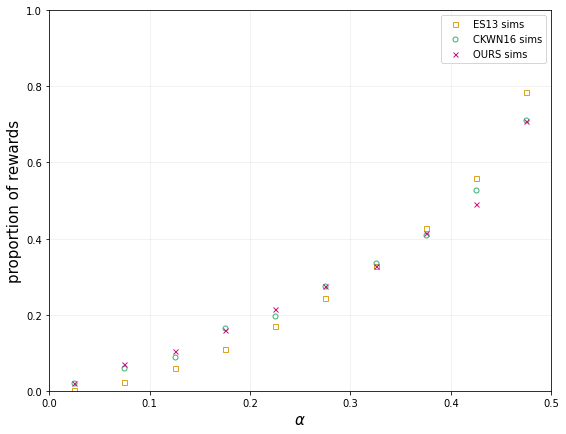

In [1020]:
f, ax = plt.subplots(figsize=(9,7))

# axins = ax.inset_axes(
#     [1.1, 0.35, 0.47, 0.47],
#     xlim=(.19, .26), ylim=(.13, .26))

# ax.indicate_inset_zoom(axins, edgecolor="black", label=None, alpha=0.25)


for a in [ax, axins]:
    a.plot(simAlphas, ES_sim_lambda_sqrt, color='goldenrod', alpha=1, label='ES13 sims', marker='s', 
           fillstyle='none', linestyle='none', markersize=5)
    a.plot(simAlphas, CKWN_sim_lambda_sqrt, color='mediumseagreen', alpha=1, label='CKWN16 sims', marker='o', 
           fillstyle='none', linestyle='none', markersize=5)
    a.plot(simAlphas, OURS_sim_lambda_sqrt, color='mediumvioletred', alpha=1, label='OURS sims', marker='x', 
           fillstyle='none', linestyle='none', markersize=5)
    


ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlim(0., 0.5)
ax.set_ylim(0.,1)

# plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# optimal beta for sqrt

In [6]:
def findOptBetaExec(alpha, gamma):
    # CKWN optimal betas (exec rewards only)
    betas  = np.arange(0.01, 5.01, 0.01)
    rews = [Carlsten2(alpha=alpha, beta=b, gamma=gamma) for b in betas]
    return betas[np.argmax(rews)]

def findOptBetaBoth(alpha, gamma, scale=1):
    # CKWN optimal betas (exec rewards only)
    betas  = np.arange(0.01, 5.01, 0.01)
    rews = [calcTotalRewardGamma(a=alpha, b=b, gamma=gamma, scale=scale) for b in betas]
    return betas[np.argmax(rews)]

In [7]:
findOptBetaExec(0.3, 0.), findOptBetaBoth(0.3, 0.)

NameError: name 'calcTotalRewardGamma' is not defined

In [105]:
alpha = 0.3
gamma = 0.0
scale = 1
betas  = np.arange(0.15, 1., 0.01)
rewsExec = [Carlsten2(alpha=alpha, beta=b, gamma=gamma) for b in betas]
rewsBoth = [calcTotalRewardGamma(a=alpha, b=b, gamma=gamma, scale=scale) for b in betas]

In [35]:
def sim_beta_linear(alpha, gamma, beta, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.random.exponential() # HERE IS DIFF
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    return attackRews, honestRews, attackBlcs, honestBlcs

In [52]:
def sim_beta_nonlinear(alpha, gamma, beta, f, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = f(np.random.exponential()) # HERE IS DIFF
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    return attackRews, honestRews, attackBlcs, honestBlcs

In [100]:
simBetas  = np.arange(0.2, 1, 0.08)
simExec = []
simBoth = []
for b in simBetas:
    print('beta={:0.3f}'.format(b), end='\r')
    temp, temp2 = [], []
    for j in range(15):
        ar, hr, ab, hb = sim_beta_linear(alpha=0.3, gamma=0.0, beta=b, n = int(2e5))
        temp.append(ar/(ar+hr))
        temp2.append((ab/(ab+hb) + scale*ar/(ar+hr))/(scale+1))
    simExec.append(np.mean(temp))
    simBoth.append(np.mean(temp2))
simExec = np.array(simExec)
simBoth = np.array(simBoth)
simExec.shape, simBoth.shape

((10,), (10,))

In [101]:
simBetas  = np.arange(0.2, 1, 0.08)
simExecSqrt = []
simBothSqrt = []
for b in simBetas:
    print('beta={:0.3f}'.format(b), end='\r')
    temp, temp2 = [], []
    for j in range(15):
        ar, hr, ab, hb = sim_beta_nonlinear(alpha=0.3, gamma=0.0, beta=b, f=np.sqrt, n = int(2e5))
        temp.append(ar/(ar+hr))
        temp2.append((ab/(ab+hb) + scale*ar/(ar+hr))/(scale+1))
    simExecSqrt.append(np.mean(temp))
    simBothSqrt.append(np.mean(temp2))
simExecSqrt = np.array(simExecSqrt)
simBothSqrt = np.array(simBothSqrt)
simExecSqrt.shape, simBothSqrt.shape

((10,), (10,))

In [106]:
findOptBetaExec(0.3, 0.), findOptBetaBoth(0.3, 0.)

(0.72, 0.49)

In [107]:
simBetas[np.argmax(simExec)], simBetas[np.argmax(simBoth)]

(0.6800000000000002, 0.52)

In [108]:
simBetas[np.argmax(simExecSqrt)], simBetas[np.argmax(simBothSqrt)]

(0.6800000000000002, 0.44000000000000006)

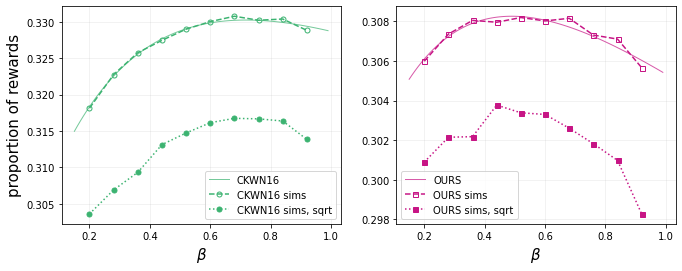

In [110]:
f, axarr = plt.subplots(ncols=2, figsize=(11,4))

# axins = ax.inset_axes(
#     [1.1, 0.35, 0.47, 0.47],
#     xlim=(.19, .26), ylim=(.13, .26))

# ax.indicate_inset_zoom(axins, edgecolor="black", label=None, alpha=0.25)



#     a.axhline(calcTotalRewardGamma(a=alpha, b=100, gamma=gamma, scale=scale), 
#               linewidth=1, color='goldenrod', alpha=0.7, label='ES13', linestyle='-')
for a in [axarr[0]]:        
    a.plot(betas, rewsExec, linewidth=1, color='mediumseagreen', alpha=0.7, label='CKWN16',
           linestyle='-')
    a.plot(simBetas, simExec, color='mediumseagreen', alpha=1, label='CKWN16 sims', marker='o', 
           fillstyle='none', linestyle='--', markersize=5)
    a.plot(simBetas, simExecSqrt, color='mediumseagreen', alpha=1, label='CKWN16 sims, sqrt', marker='o', 
           fillstyle='full', linestyle='dotted', markersize=5)

for a in [axarr[1]]:
    a.plot(betas, rewsBoth, linewidth=1, color='mediumvioletred', alpha=0.7, label='OURS', 
            linestyle='-')
    a.plot(simBetas, simBoth, color='mediumvioletred', alpha=1, label='OURS sims', marker='s', 
           fillstyle='none', linestyle='--', markersize=5)
    a.plot(simBetas, simBothSqrt, color='mediumvioletred', alpha=1, label='OURS sims, sqrt', marker='s', 
           fillstyle='full', linestyle='dotted', markersize=5)
    
    
#     a.plot(alphas,alphas, color='k', alpha=0.3)

for ax in axarr:
    ax.set_xlabel(r'$\beta$', size=15)

    ax.grid(alpha=0.2)
    ax.legend()
axarr[0].set_ylabel(r'proportion of rewards', size=15)
    
plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [74]:
simBetas  = np.arange(0.2, 1, 0.08)
simBetas.shape, simBetas

((10,), array([0.2 , 0.28, 0.36, 0.44, 0.52, 0.6 , 0.68, 0.76, 0.84, 0.92]))

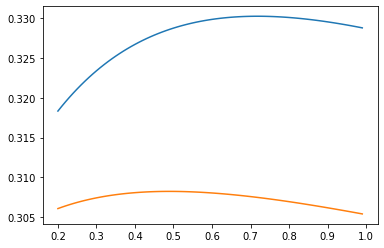

In [66]:
plt.plot(betas, rewsExec)
plt.plot(betas, rewsBoth)

# 

In [ ]:
def simCKWN_beta_lambda_sqrt(alpha, gamma, beta, scale=1, n = int(1e5)):
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, alpha)
        execRews = np.sqrt(np.random.exponential()) # HERE IS DIFF
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if execRews < beta:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                if sample < alpha:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                elif sample <= alpha + ((1-alpha)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, alpha)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]

    totalRews = honestRews + attackRews
    totalBlcs = honestBlcs + attackBlcs
    return ((scale*(attackRews/totalRews)) + (attackBlcs/totalBlcs)) / (scale+1)

In [ ]:
alphas     = np.arange(0.01, 0.5, 0.001)
gammas     = [0, 0.5, 1]

ES_theo    = []
CKWN2_theo = []
for g in gammas:
    ES_theo.append([EyalSirer(a, g) for a in alphas])
    CKWN2_theo.append([selfishCNum(a, g) for a in alphas])
ES_theo    = np.array(ES_theo)
CKWN2_theo = np.array(CKWN2_theo)
ES_theo.shape, CKWN2_theo.shape

In [ ]:
state = 0
alpha = 0.3

honestRews = 0
attackRews = 0
remainRews = 0
honestBlcs = 0
attackBlcs = 0

for _ in tqdm(range(int(1e5))):
    blockTime = np.random.exponential(1/100000)
    attBlock  = np.random.binomial(1, alpha)

    if state == 0 and attBlock:
        state       = 1
        remainRews += blockTime  # unclaimed exec rewards on private branch
    elif state == 0 and not attBlock:
        honestRews += blockTime
        honestBlcs += 1

    if state == 1 and attBlock:
        state       = 2
        attackRews += (remainRews + blockTime)  # attacker locks in both blocks worth of exec rewards
        attackBlcs += 2
        remainRews  = 0
    elif state == 1 and not attBlock:
        nextBlockTime = np.random.exponential()
        nextAttBlock  = np.random.binomial(1, alpha)
        # attacker wins all three time period's worth of exec rewards
        if nextAttBlock:
            attackRews += (remainRews + blockTime + nextBlockTime)
            attackBlcs += 2
        #   honest wins all three time period's worth of exec rewards
        else:
            honestRews += (remainRews + blockTime + nextBlockTime)
            honestBlcs += 2
        remainRews = 0

    if state == 2 and attBlock:
        state        = 3
        attackRews  += (remainRews + blockTime)
        remainRews   = 0
        attackBlcs  += 1
    elif state == 2 and not attBlock:
        nextBlockTime = np.random.exponential()
        nextAttBlock  = np.random.binomial(1, alpha)
        # attacker wins all outstanding exec rewards
        if nextAttBlock:
            attackRews += (remainRews + blockTime + nextBlockTime)
            attackBlcs  += 1
        #   honest wins all outstanding exec rewards
        else:
            honestRews  += (remainRews + blockTime + nextBlockTime)
            honestBlcs  += 1
        remainRews = 0

    if state > 2 and attBlock:
        state        += 1
        attackRews   += (remainRews + blockTime)
        remainRews    = 0
        attackBlcs   += 1
    elif state > 2 and not attBlock:
        state      -= 1
        remainRews += blockTime

totalRews = honestRews + attackRews
totalBlcs = honestBlcs + attackBlcs
(honestRews/totalRews, attackRews/totalRews), (honestBlcs/totalBlcs, attackBlcs/totalBlcs), honestBlcs, totalBlcs